# Tutorial for params_MOT

This package fits various parameters to images of molecules or atoms trapped in a magneto-optical trap (MOT).

In [1]:
%matplotlib inline 

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage.filters as filters
import seaborn as sns
import pandas as pd
import os

import math
import emcee

from params_MOT.io_package import get_data_file_path, load_data
from params_MOT.model import *
from params_MOT import MOT_image
import params_MOT as pm

from scipy.optimize import curve_fit

### Set parameters

In [2]:
#mc_params=(Walkers,Steps)
mc_params=(200,800)

#initial_guess = [center_x, center_y, amplitude, sigma_x, sigma_y, background_offset, sigma_m, readout_charge]
initial_guess = [25, 25, 100, 10, 10, 100, 20, 60]


### Run Model on Data and Show Results

The MCMC is contained in the function find_params_MOT in model.py. This function runs MCMC using the pm.sampler function, which calls upon the emcee package to compute marginal posteriors for the model parameters. There are 8 parameters to be marginalized over, which is encompassed in the variable theta in our package. theta is an array consisting of the following parameters:
(center_x, center_y, amplitude, sigma_x, sigma_y, background_offset, sigma_m, sigma_g)
The first 5 parameters give the 2D Gaussian for the MOT. background_offset is self-explanator. sigma_m is the uncertainty in the model, and sigma_m is the uncertainty from the scattered light background. When calling upon the find_params_MOT function, we have to specify an 8-tuple consisting of the initial guesses for theta, and also the duple mc_params = (nwalkers, nsteps) which controls the parameters of the MCMC.
From there one only needs to specify the filename of the data (which is presumed to be in the root folder of params_MOT, and the function will automatically run the MCMC and conclude the best fit parameters from the 50th percentile of the final state of the walkers.

#### Note on data file title format:
The data is stored in .csv files, using the following title convention (this is important because information is stored in the title, too): <br><br>
(time in ms)\_(series number)_(fraction of maximum laser power)power.csv
<br><br>
For example, the title '3_1_16power.csv' (used in the example below) means that the picture of the MOT was taken 3 ms after realising it from the trap, that the picture is part of the 1st series, and that the laser power used is $\frac{max\_power}{16}  = \frac{60}{16} \mathrm{mW}$. Not respecting the convention should rise an error pointing this out.
<br><br>
The directory in which the data is stored is given by the data_dir parameter. Nominally, we store the data in the GitHub/params_MOT/data folder.

Loading data...
The life time of and the laser power used on the MOT are 3 ms and 1/16 (fractional units out of the max power, which is 60mW per beam)
Data loaded. Setting up emcee sampler...
Emcee sampler setup finished. Running MCMC...
       sigma_x   sigma_y
0.16  5.172327  5.484240
0.50  5.301186  5.662868
0.84  5.435942  5.875847


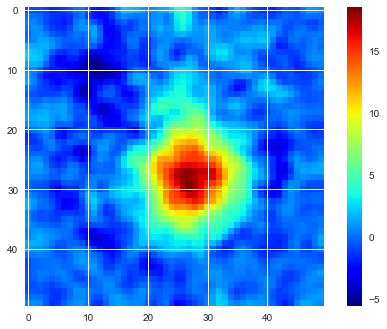

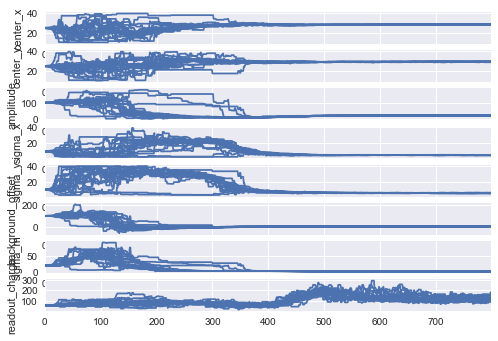

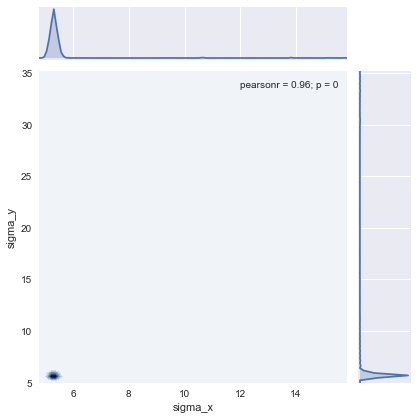

In [4]:
a = find_params_MOT('3_1_16power.csv', data_dir = 'data', image_size = 50, mc_params = mc_params, initial_guess = initial_guess, supressMessages = False)

## Get the temperature

To get the temperature from the MOT size (i.e., from the standard deviations $\sigma_\mathrm{x}$ and $\sigma_\mathrm{y}$) we use the following formula: $$\sigma^2 = \sigma^2_{\mathrm{0}} + K_\mathrm{B} T \tau^2 /m,$$ where $\sigma$ stands for either $\sigma_{\mathrm{x}}$ or $\sigma_{\mathrm{y}}$, $\tau$ is the time, $T$ is temperature, $K_\mathrm{B}$ the Boltzmann constant, and $m$ the mass (= 59 amu = 9.80e-26 kg). 

The first step is to run the sampler on a list of data files. Belowe we get a list of all the .csv files in the folder given by the data_path string. The printed data_files array has the list of these files, which should ideally be part of the same series, with the same used power, and different times (['0.5_1_16power.csv', '2_1_16power.csv', '3_1_16power.csv', '4_1_16power.csv'] is a good example). You can change the array to drop/add files before calling the function to do the fitting to the data.

In [3]:
# Get the data files 
#(NOTE: this works if you have a folder called "data" one step up from the main repo folder; the data folder is not uploaded on GitHub)
data_path = 'data'
data_files = [f for f in os.listdir(data_path) if (os.path.isfile(os.path.join(data_path, f)) and f.split('.')[-1] == 'csv')]
print(data_files)

['0.5_1_16power.csv', '2_1_16power.csv', '3_1_16power.csv', '4_1_16power.csv']


In [4]:
# Run sampler on all data files
q = find_params_MOTs(data_files, 'data', 50, mc_params, initial_guess, supressMessages = True)

Call function to infer the temeprature for the MOT, corresponding to each direction (for one number use formula $T = T_{\mathrm{x}}^{2/3} \times T_{\mathrm{y}}^{1/3}$).

NOTE: 
   - The true image size is 20 mm x 20 mm, so account for that too.
   - Time is in ms.
   - The power is given as the fraction of the max_power (which is 60 mW). 

     time    power   sigma_x  sigma_sigma_x   sigma_y  sigma_sigma_y  \
0  0.0005  0.00375  0.001925   9.446301e-07  0.001739   2.107061e-07   
1  0.0020  0.00375  0.002012   2.330401e-07  0.001965   3.933139e-07   
2  0.0030  0.00375  0.002119   1.103881e-06  0.002259   2.482281e-06   
3  0.0040  0.00375  0.002452   6.062381e-07  0.002340   7.372591e-07   

   sigma_x_squared  sigma_sigma_x_squared  sigma_y_squared  \
0         0.000004           1.889260e-06         0.000003   
1         0.000004           4.660801e-07         0.000004   
2         0.000004           2.207761e-06         0.000005   
3         0.000006           1.212476e-06         0.000005   

   sigma_sigma_y_squared  
0           4.214123e-07  
1           7.866278e-07  
2           4.964563e-06  
3           1.474518e-06  
The covariance matrix is 
 [[  1.07666931e-14  -1.27092667e-09]
 [ -1.27092667e-09   2.34894101e-04]]


The fitted model, including uncertainties is (0.1567 +- 0.0153)x^2 + (0 +- 0)


The covar

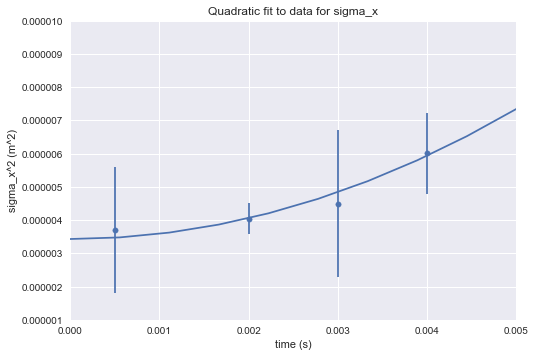

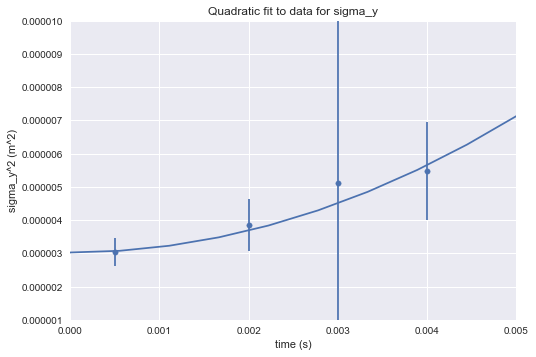

The fitted temepratures: T_x = 1.112821 mK, T_y = 1.166901 mK, T = 1.130563 mK


[0.0011128211859360779, 0.0011669011696491393, 0.0011305634694374603]

In [5]:
pm.find_MOT_temp (q, pixel_distance_ratio = 0.4*10**(-3), time_conversion_ratio = 10**(-3), max_power = 60*10**(-3), supressMessages = False)

The temperature of $\approx 1$ mK is what we expect.

Note that the uncertainties' magnitude varies greatly for each sampler run.